In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

yf.pdr_override()

y_symbol_pairs = [('^GSPC', 'USD'), ('^MXX', 'MXN'), ('^FCHI', 'EUR'), ('^NYA', 'USD'),('^JKSE', 'IDR'), ('^RUT', 'USD'), ('^KS11', 'KRW')]
y_symbol_pairs = [('^GSPC', 'USD'), ('^MXX', 'MXN'), ('^HSI', 'HKD'), ('^N225', 'JPY'),('^JKSE', 'IDR'), ('^N100', 'EUR'), ('^KLSE', 'MYR')]

#y_symbols = ['^GSPC' , '^MXX', '^FCHI','^NYA','^JKSE', '^RUT', '^KS11' ]
#y_symbols = ['AAPL', 'MSFT', 'KO', 'PEP', 'GE', 'GM', 'F' ]


start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2020,1,2)


In [2]:
def convert_to_USD(index_data, currency):
    if currency == 'USD':
        return index_data
    # get historical conversion rate to USD
    tckr = yf.Ticker(currency+"USD=X")
    df = tckr.history(start=start_date, end=end_date)
    # fixing stupid error in the data
    if currency=="IDR":
        df.loc["2010-11-01"]=df.loc["2010-11-02"]
    currency_data = df.resample('BMS').first()
    
    # convert the data
    for item in index_data.items():
        closest_date = currency_data.index[currency_data.index.get_loc(item[0], method='nearest')]
        #print(item[0])
        #print("closest date: " + str(closest_date))
        #print("before: " + str(item[1]))
        exchange_rate = currency_data.loc[closest_date]["Open"]
        #print("exchange_rate: " + str(exchange_rate))
        index_data[item[0]] = item[1]*exchange_rate
        #print("after: " + str(index_data[item[0]]))
        #print("________________________________")
    
    return index_data

In [3]:
data = pdr.get_data_yahoo([symbol for symbol, _ in y_symbol_pairs], start=start_date, end=end_date, interval='1mo')['Adj Close']

for symbol, currency in y_symbol_pairs:
    data[symbol] = convert_to_USD(data[symbol], currency)


[*********************100%***********************]  7 of 7 completed


C:\Users\fiori\AppData\Local\Temp\ipykernel_1308\185822286.py:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  closest_date = currency_data.index[currency_data.index.get_loc(item[0], method='nearest')]
C:\Users\fiori\AppData\Local\Temp\ipykernel_1308\185822286.py:14: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_date = currency_data.index[currency_data.index.get_loc(item[0], method='nearest')]
C:\Users\fiori\AppData\Local\Temp\ipykernel_1308\185822286.py:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  closest_date = currency_data.index[currency_data.index.get_loc(item[0], method='nearest')]
C:\

In [4]:
# 10 years sliding window
sliding_windows_data = {}

for j in range(11):
    i=12*j
    returns = (data / data.shift(1))[1+i:12*10+i]
    logReturn = np.log(returns)
    #var(aX) = a^2var(X), cov(aX, aX) = a^2 cov(X,X)
    #print(returns)
    yearly_mean = 12 * logReturn.mean()
    yearly_var = 12 * logReturn.var()
    yearly_std = np.sqrt(yearly_var)
    yearly_cov = 12 * logReturn.cov()
    
    dates = (data.index[i], data.index[12*10+i])

    sliding_windows_data[str(j+1) +'_yearly_mean'] = yearly_mean
    sliding_windows_data[str(j+1) +'_yearly_var'] = yearly_var
    sliding_windows_data[str(j+1) +'_yearly_std'] = yearly_std
    sliding_windows_data[str(j+1) +'_yearly_cov'] = yearly_cov
    sliding_windows_data[str(j+1) +'_dates'] = dates
    
    

In [5]:
#expected yearly returns:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_mean'])
    print("____________________________________________________________")

SLIDING WINDOW  1
^GSPC   -0.022544
^HSI     0.006737
^JKSE    0.131009
^KLSE    0.043844
^MXX     0.145157
^N100   -0.008553
^N225   -0.045249
dtype: float64
____________________________________________________________
SLIDING WINDOW  2
^GSPC   -0.008335
^HSI     0.008188
^JKSE    0.218437
^KLSE    0.091991
^MXX     0.168452
^N100   -0.030290
^N225    0.001220
dtype: float64
____________________________________________________________
SLIDING WINDOW  3
^GSPC    0.010771
^HSI     0.027717
^JKSE    0.205159
^KLSE    0.093878
^MXX     0.149197
^N100   -0.016468
^N225    0.036468
dtype: float64
____________________________________________________________
SLIDING WINDOW  4
^GSPC    0.051513
^HSI     0.065923
^JKSE    0.211405
^KLSE    0.118175
^MXX     0.186215
^N100    0.036164
^N225    0.058998
dtype: float64
____________________________________________________________
SLIDING WINDOW  5
^GSPC    0.049521
^HSI     0.056773
^JKSE    0.142523
^KLSE    0.099874
^MXX     0.136537
^N100    0.0

In [6]:
#cov_matrices:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_cov'])
    print("____________________________________________________________")

SLIDING WINDOW  1
          ^GSPC      ^HSI     ^JKSE     ^KLSE      ^MXX     ^N100     ^N225
^GSPC  0.026898  0.028728  0.020098  0.013397  0.030335  0.029928  0.017015
^HSI   0.028728  0.057004  0.033806  0.023156  0.037867  0.034807  0.028817
^JKSE  0.020098  0.033806  0.095920  0.031872  0.043570  0.029823  0.027365
^KLSE  0.013397  0.023156  0.031872  0.036452  0.023242  0.021421  0.011107
^MXX   0.030335  0.037867  0.043570  0.023242  0.060982  0.037311  0.024748
^N100  0.029928  0.034807  0.029823  0.021421  0.037311  0.049451  0.023723
^N225  0.017015  0.028817  0.027365  0.011107  0.024748  0.023723  0.046403
____________________________________________________________
SLIDING WINDOW  2
          ^GSPC      ^HSI     ^JKSE     ^KLSE      ^MXX     ^N100     ^N225
^GSPC  0.027883  0.029054  0.021728  0.013522  0.029539  0.031315  0.019312
^HSI   0.029054  0.052937  0.032919  0.022611  0.032506  0.035213  0.030493
^JKSE  0.021728  0.032919  0.089497  0.032739  0.039543  0.033278  

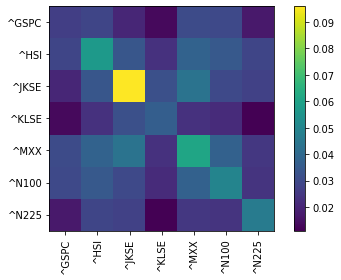

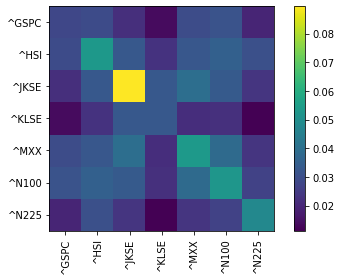

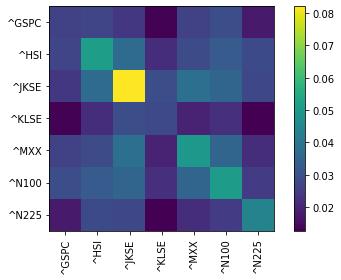

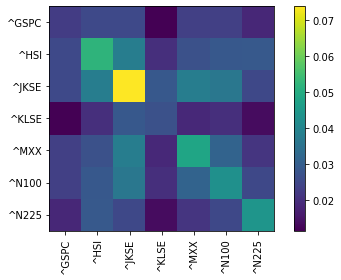

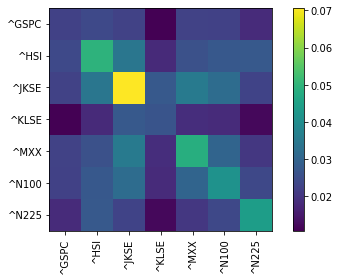

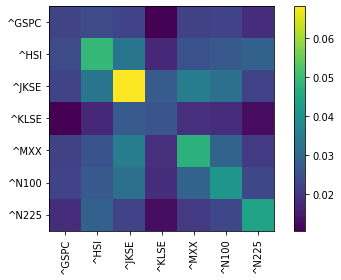

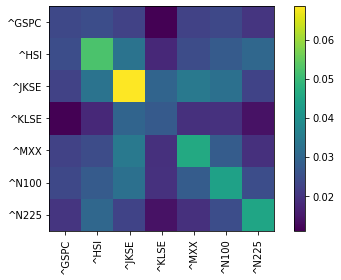

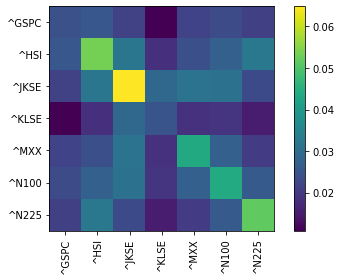

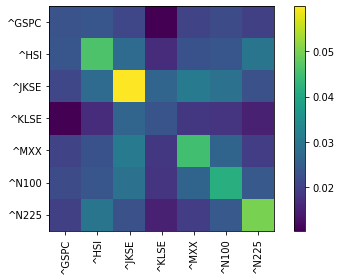

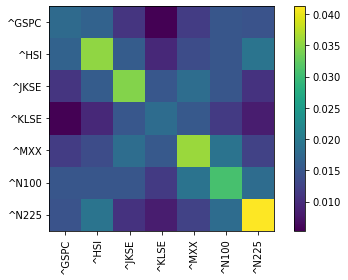

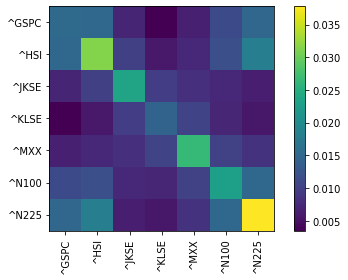

In [7]:
from pypfopt.plotting import plot_covariance
#cov_matrices:
for j in range(11):
    plot_covariance(sliding_windows_data[str(j+1) +'_yearly_cov'])

In [8]:
# just testing code
weights = [0, 0.3, 0.1, -0.2, -0.3, 0, 0.1, 0]
sum_of_positives = sum([max(weight, 0) for weight in weights])
if 0 < sum_of_positives < 1:
    weights = [weight*(1/sum_of_positives) for weight in weights]
weights

shorting_allowed = 0.5

# normalize (all negative values should add up to a value lower than the shorting_allowed value)
sum_of_negatives = sum([min(weight, 0) for weight in weights])
if shorting_allowed < abs(sum_of_negatives):
    weights = [weight*(shorting_allowed/abs(sum_of_negatives)) if weight < 0 else weight for weight in weights]

weights

[0.0, 0.6, 0.2, -0.2, -0.3, 0.0, 0.2, 0.0]

#### Efficient frontiers

C:\Users\fiori\AppData\Local\Temp\ipykernel_1308\236208855.py:30: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights)


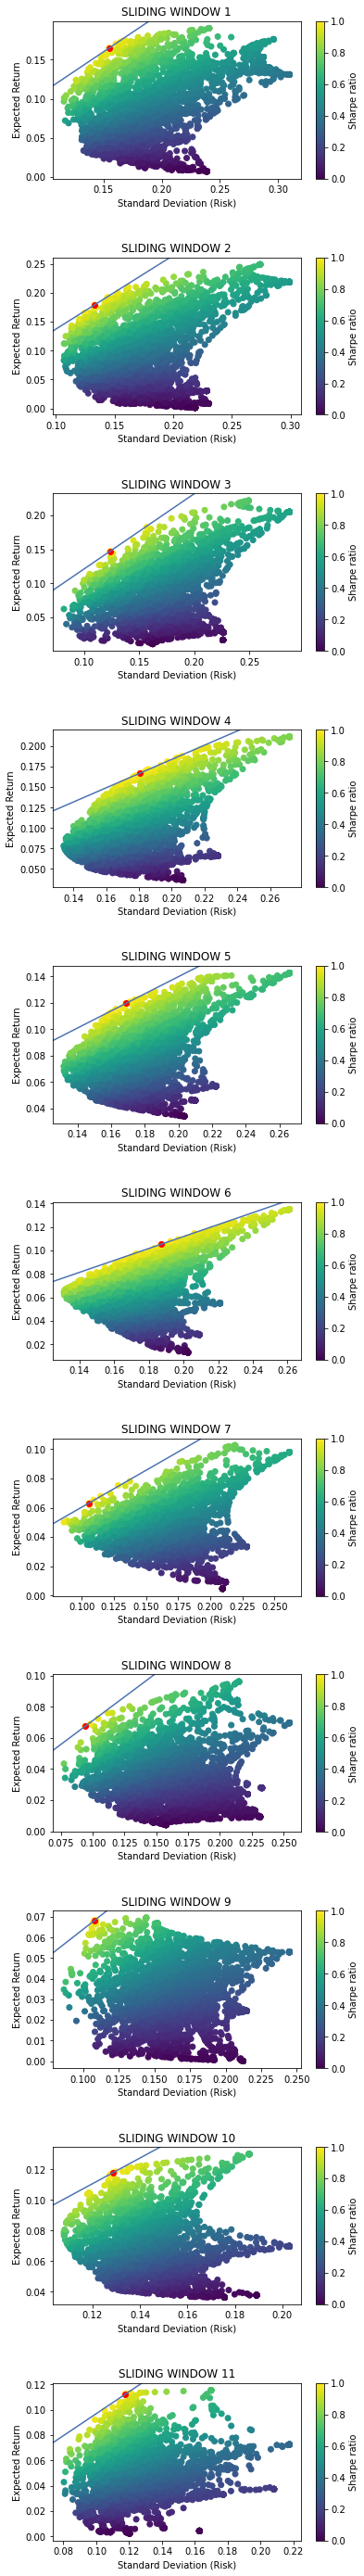

In [9]:
import numpy as np
import matplotlib.pyplot as plt

risk_free_rate = 0.01

# x of the portfolio value allowed to be shorted
shorting_allowed = 1

 #take a list of lists of frontier returns and variances
f_r = []
f_v = []
sharper = []
#w = [] #append weights for each portfolio
frontiers_portfolios = []
highest_sharper_portfolios = []

for j in range(11):
    returns = sliding_windows_data[str(j+1) +'_yearly_mean']
    covariances = sliding_windows_data[str(j+1) +'_yearly_cov']
    shorting = [1]*len(returns)
    if shorting_allowed:
        shorting = [-1 if a<0 else 1 for a in returns]

    frontier_mean_returns = []
    frontier_stds = []
    w = []
    for i in range(3000):
        weights = np.random.normal(0, 1, size=len(returns)) #use normal distribution
        weights = [x if x >= 0 else 0 for x in weights]  
        weights /= np.sum(weights)
        # make weights negative where shorting is necessary
        weights = weights*shorting
        # normalize (all positive values should add up to 1)
        sum_of_positives = sum([max(weight, 0) for weight in weights])
        if 0 < sum_of_positives < 1:
            weights = weights*(1/sum_of_positives)
        
        # normalize (all negative values should add up to a value lower than the shorting_allowed value)
        sum_of_negatives = sum([min(weight, 0) for weight in weights])
        if shorting_allowed < abs(sum_of_negatives):
            weights = np.array([weight*(shorting_allowed/abs(sum_of_negatives)) if weight < 0 else weight for weight in weights])
        
        
        if np.isnan(weights).any():
            continue
        portfolio_return = np.sum(returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))
        frontier_mean_returns.append(portfolio_return)
        frontier_stds.append(portfolio_std)
        w.append(weights)
    frontiers_portfolios.append(w)
    f_r.append(frontier_mean_returns)
    f_v.append(frontier_stds)

    # highest sharper portfolio
    sharper.append(np.array(frontier_mean_returns) / np.array(frontier_stds))
    index = sharper[-1].argmax(axis=0)
    highest_sharper_portfolios.append({
        "dates": sliding_windows_data[str(j+1) +'_dates'],
        "return": frontier_mean_returns[index],
        "std": frontier_stds[index],
        "weights": frontiers_portfolios[j][index]})
    #print(highest_sharper_portfolios[-1]["return"])
    #print(sum(sliding_windows_data[str(j+1) +'_yearly_mean']*highest_sharper_portfolios[-1]["weights"]))

    

    
# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    im = axs[i].scatter(f_v[i], f_r[i], c=sharper[i])
    im = axs[i].scatter(highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"], c="red")
    # plotting capital market line (tobin separation)
    # equivalent to 
    #axs[i].axline((0, risk_free_rate), (highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"]))
    # but prettier
    axs[i].axline(
        (min(f_v[i]), (min(f_v[i])/highest_sharper_portfolios[i]["std"])*(highest_sharper_portfolios[i]["return"]-risk_free_rate)+risk_free_rate),
        (highest_sharper_portfolios[i]["std"], highest_sharper_portfolios[i]["return"]))
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    plt.colorbar(im, ax=axs[i], label = 'Sharpe ratio')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()



In [10]:
# Asset Allocation (uncomment last line to prove that code works)
# I'm calculating optimal asset allocation and turnover for each time window. Maybe we're supposed to do it for each year idk

# required rate of return
rrr = 0.05
borrowing_allowed = True

# optimal asset allocation:
# mix of max sharpe ratio portfolio and risk free rate that reaches RRR

for i, portfolio in enumerate(highest_sharper_portfolios):

    risk_free_rate_portion = (rrr - portfolio["return"]) / (risk_free_rate - portfolio["return"])

    if not borrowing_allowed:
        # make sure it's between 0 and 1
        risk_free_rate_portion = 1 if risk_free_rate_portion>1 else 0 if risk_free_rate_portion<0 else risk_free_rate_portion

    highest_sharper_portfolios[i]["risk_free_rate_portion"] = risk_free_rate_portion
    highest_sharper_portfolios[i]["weights_incl_rf"] = np.append(portfolio["weights"]*(1-risk_free_rate_portion), risk_free_rate_portion)

    if risk_free_rate_portion>=0:
        print(f"""{round(risk_free_rate_portion*100)}% of the portfolio in window {str(i+1)} should be risk free at {risk_free_rate*100}%, the remaining {round((1-risk_free_rate_portion)*100)}% have a return of {round(portfolio["return"]*100)}%""")
    else:
        print(f"""Everything of the portfolio in window {str(i+1)} should be invested with a leverage of {round((1-risk_free_rate_portion),2)} (invest 100% + {round((-risk_free_rate_portion)*100)}% that was borrowed at {risk_free_rate*100}%)""")


    # check if calculation was correct
    print(f"The total return of the portfolio is {round((risk_free_rate_portion*risk_free_rate + (1-risk_free_rate_portion)*portfolio['return'])*100, 1)}%")


74% of the portfolio in window 1 should be risk free at 1.0%, the remaining 26% have a return of 17%
The total return of the portfolio is 5.0%
76% of the portfolio in window 2 should be risk free at 1.0%, the remaining 24% have a return of 18%
The total return of the portfolio is 5.0%
71% of the portfolio in window 3 should be risk free at 1.0%, the remaining 29% have a return of 15%
The total return of the portfolio is 5.0%
75% of the portfolio in window 4 should be risk free at 1.0%, the remaining 25% have a return of 17%
The total return of the portfolio is 5.0%
63% of the portfolio in window 5 should be risk free at 1.0%, the remaining 37% have a return of 12%
The total return of the portfolio is 5.0%
58% of the portfolio in window 6 should be risk free at 1.0%, the remaining 42% have a return of 11%
The total return of the portfolio is 5.0%
25% of the portfolio in window 7 should be risk free at 1.0%, the remaining 75% have a return of 6%
The total return of the portfolio is 5.0%


In [11]:
# turnover
# For turnover I'm considering all assets, not just risk free. Not sure if it's correct.
for i, (portfolio, previous_portfolio) in enumerate(zip(highest_sharper_portfolios[1:], highest_sharper_portfolios)):
    
    # parts of the portfolio that remain the same from the previous portfolio
    unchanged_assets = [min(weight_pair) for weight_pair in zip(portfolio["weights_incl_rf"], previous_portfolio["weights_incl_rf"])]
    turnover_rate = 1-sum(unchanged_assets)
    print(f"turnover rate from sliding window {i+1} to {i+2} is {round(turnover_rate*100)}%")


turnover rate from sliding window 1 to 2 is 45%
turnover rate from sliding window 2 to 3 is 30%
turnover rate from sliding window 3 to 4 is 19%
turnover rate from sliding window 4 to 5 is 13%
turnover rate from sliding window 5 to 6 is 14%
turnover rate from sliding window 6 to 7 is 87%
turnover rate from sliding window 7 to 8 is 97%
turnover rate from sliding window 8 to 9 is 82%
turnover rate from sliding window 9 to 10 is 83%
turnover rate from sliding window 10 to 11 is 26%


In [12]:
weights*len(weights)

array([ 0.        ,  1.53753865,  0.17528698,  4.48618903, -2.99522685,
        0.80098535,  0.        ])

In [13]:
# Backtest (uncomment returns line and change the 12 to 119 to prove the code works (you should get aprox. 10x rrr))

monthly_portfolio_logReturns = None

for i, portfolio in enumerate(highest_sharper_portfolios[:-1]):
    
    # print year
    print(f"Year: {portfolio['dates'][1].year}")

    weights = portfolio["weights_incl_rf"]

    # connect symbol of each asset to weight the asset has in the portfolio
    symbol_weight_pairs = list(zip(list(data.columns)+["risk free asset"], weights))
    # divide into long and short, drop weights that are 0
    long_symbol_weight_pairs = [pair for pair in symbol_weight_pairs if pair[1]>0]
    short_symbol_weight_pairs = [pair for pair in symbol_weight_pairs if pair[1]<0]
    # print symbol weight pairs
    print(f"Weights: {', '.join( [str(round(weight*100))+'% '+symbol for symbol, weight in long_symbol_weight_pairs] )}")
    if short_symbol_weight_pairs:
        print(f"Shorting: {', '.join( [str(round(weight*100))+'% '+symbol for symbol, weight in short_symbol_weight_pairs] )}")


    # return from the year that starts immediately after the sliding window
    returns = (data / data.shift(1))[i*12+120:i*12+120+12]
    #returns = (data / data.shift(1))[1+i*12:12*10+i*12] # uncomment this
    logReturn = np.log(returns)
    # add column for risk free asset
    logReturn["rf"] = [risk_free_rate/12]*12 # change last 12 to 119
    logReturn_weighted = (logReturn*weights).sum(axis=1)
    monthly_portfolio_logReturns = pd.concat([monthly_portfolio_logReturns, logReturn_weighted])
    #print(logReturn_weighted.sum(axis=1))
    #print(logReturn_weighted)
    logReturn_total = logReturn_weighted.sum()
    # total weighted return for the year
    print(f"Return: {str(round(logReturn_total*100))}%")
    
    # this works too but is more complicated
    #covariances = logReturn.cov()
    #portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))

    portfolio_std = np.sqrt(logReturn_weighted.var())

    print(f"Standard deviation: " + str(round(portfolio_std,4)))
    

Year: 2010
Weights: 2% ^JKSE, 2% ^KLSE, 22% ^MXX, 74% risk free asset
Shorting: -15% ^GSPC, -3% ^N100, -7% ^N225
Return: 5%
Standard deviation: 0.0104
Year: 2011
Weights: 5% ^JKSE, 5% ^KLSE, 13% ^MXX, 0% ^N225, 76% risk free asset
Shorting: -7% ^GSPC, -12% ^N100
Return: 1%
Standard deviation: 0.0089
Year: 2012
Weights: 4% ^JKSE, 10% ^KLSE, 15% ^MXX, 71% risk free asset
Shorting: -16% ^N100
Return: 4%
Standard deviation: 0.0085
Year: 2013
Weights: 4% ^JKSE, 9% ^KLSE, 12% ^MXX, 75% risk free asset
Return: 0%
Standard deviation: 0.0066
Year: 2014
Weights: 2% ^JKSE, 17% ^KLSE, 17% ^MXX, 63% risk free asset
Return: -2%
Standard deviation: 0.0113
Year: 2015
Weights: 16% ^JKSE, 14% ^KLSE, 12% ^MXX, 58% risk free asset
Return: -9%
Standard deviation: 0.0156
Year: 2016
Weights: 28% ^GSPC, 19% ^JKSE, 23% ^KLSE, 5% ^MXX, 25% risk free asset
Shorting: -47% ^N100
Return: 2%
Standard deviation: 0.0179
Year: 2017
Weights: 49% ^GSPC, 20% ^JKSE, 30% risk free asset
Shorting: -22% ^MXX, -28% ^N100
Retur

In [14]:
#CAPM (probably wrong idk xD)
index_symbol = 'XWD.TO' # msci world
start_date_plus_10 = start_date.replace(year = start_date.year + 10)
data_broad_market = pdr.get_data_yahoo(index_symbol, start=start_date_plus_10, end=end_date, interval='1mo')['Adj Close']

market_returns = data_broad_market / data_broad_market.shift(1)
market_logReturn = np.log(market_returns).shift(periods=-1)[:-1]
market_logReturn.name = 'market returns'
monthly_portfolio_logReturns.name = 'portfolio returns'

both_returns = pd.concat([monthly_portfolio_logReturns, market_logReturn], axis=1)

market_yearly_mean = 12 * market_logReturn.mean()
portfolio_yearly_mean = 12 * monthly_portfolio_logReturns.mean()
portfolio_yearly_var = 12 * monthly_portfolio_logReturns.var()
portfolio_yearly_cov = 12 * both_returns.cov()


beta = portfolio_yearly_cov['market returns']['portfolio returns'] / portfolio_yearly_var
market_return = market_yearly_mean # is this right??
expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
jensens_alpha = portfolio_yearly_mean - (risk_free_rate + beta * (market_return - risk_free_rate))


[*********************100%***********************]  1 of 1 completed


In [15]:
#The results might change between runs because the points are computed at random

In [16]:
for i in range(len(f_r)):
    print("Highest return portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(f_r[i])])
    print("__________________________________________")

Highest return portfolio, Sliding Window  1
[-0.  0.  0.  0.  1. -0. -1.]
__________________________________________
Highest return portfolio, Sliding Window  2
[-0.  0.  1.  0.  0. -1.  0.]
__________________________________________
Highest return portfolio, Sliding Window  3
[ 0.  0.  1.  0.  0. -1.  0.]
__________________________________________
Highest return portfolio, Sliding Window  4
[0. 0. 1. 0. 0. 0. 0.]
__________________________________________
Highest return portfolio, Sliding Window  5
[0. 0. 1. 0. 0. 0. 0.]
__________________________________________
Highest return portfolio, Sliding Window  6
[0. 0. 1. 0. 0. 0. 0.]
__________________________________________
Highest return portfolio, Sliding Window  7
[ 0.  0.  1.  0.  0. -1.  0.]
__________________________________________
Highest return portfolio, Sliding Window  8
[ 0.  0.  1.  0. -0. -1.  0.]
__________________________________________
Highest return portfolio, Sliding Window  9
[ 1.  0.  0.  0.  0. -1.  0.]
___________

In [17]:
# Less risky portfolio
for i in range(len(f_r)):
    print("Lowest risk portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmin(f_v[i])])
    print("__________________________________________")

Lowest risk portfolio, Sliding Window  1
[-0.68476291  0.40537024  0.          0.21857729  0.37605247 -0.
 -0.31523709]
__________________________________________
Lowest risk portfolio, Sliding Window  2
[-0.          0.12055554  0.          0.34384376  0.19427459 -0.56680884
  0.34132612]
__________________________________________
Lowest risk portfolio, Sliding Window  3
[ 0.53260937  0.          0.          0.40093087  0.06645976 -0.5352793
  0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  4
[0.60177933 0.         0.         0.39822067 0.         0.
 0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  5
[0.55536174 0.         0.         0.44463826 0.         0.
 0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  6
[0.49037561 0.         0.         0.45400576 0.         0.
 0.05561863]
__________________________________________
Lowest risk portfolio, Slidi

In [18]:
#Highest sharpe ratio

for i in range(11):
    SharpeR = np.array(f_r[i]) / np.array(f_v[i])
    print("Highest Sharpe-ratio portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(SharpeR)])
    print("__________________________________________")

Highest Sharpe-ratio portfolio, Sliding Window  1
[-0.60038326  0.          0.06639757  0.06046379  0.87313864 -0.12171317
 -0.27790356]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  2
[-0.31081404  0.          0.2270406   0.23197285  0.53152799 -0.52007037
  0.00945856]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  3
[ 0.          0.          0.14685352  0.34449701  0.50864946 -0.53365331
  0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  4
[0.         0.         0.16763686 0.34636793 0.48599521 0.
 0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  5
[0.         0.         0.05890952 0.47342318 0.4676673  0.
 0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  6
[0.         0.         0.3867713  0.32481931 0.28840939 0.
 0.        ]
________

# Let's try to replicate the previous efficient frontiers with a library

In [19]:
!pip install PyPortfolioOpt

Defaulting to user installation because normal site-packages is not writeable


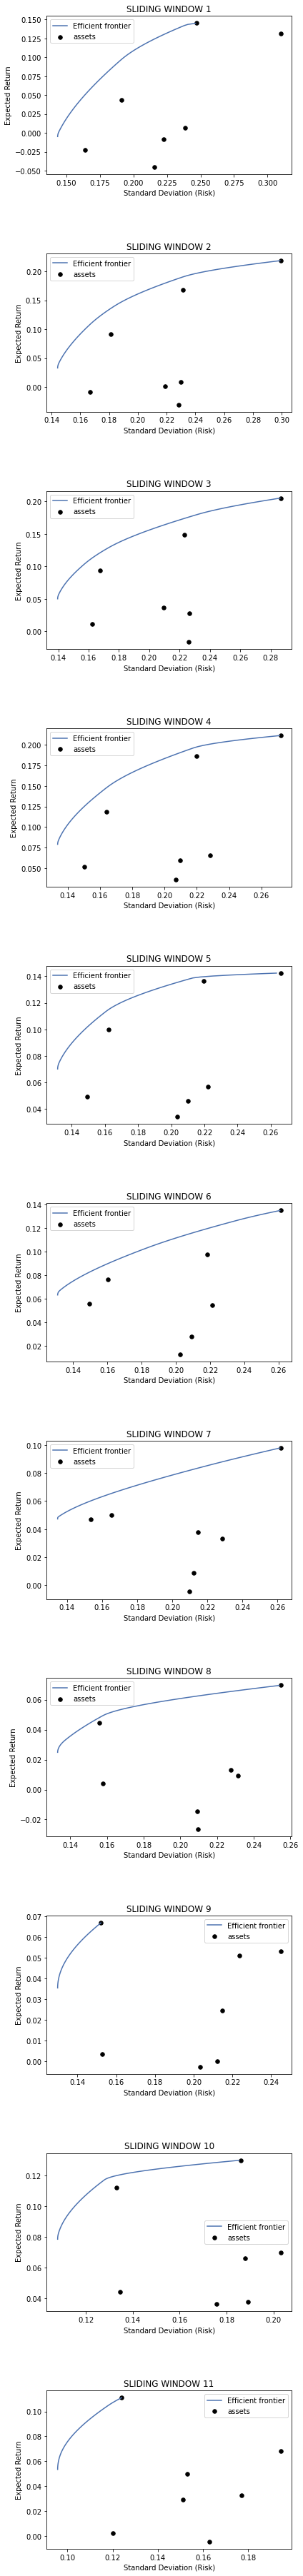

In [20]:
from pypfopt import EfficientFrontier
from pypfopt import plotting

# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()

### The results are the same, we can use the library to use compute the efficient frontier with risk free rate 1

## Efficient frontier risk free rate

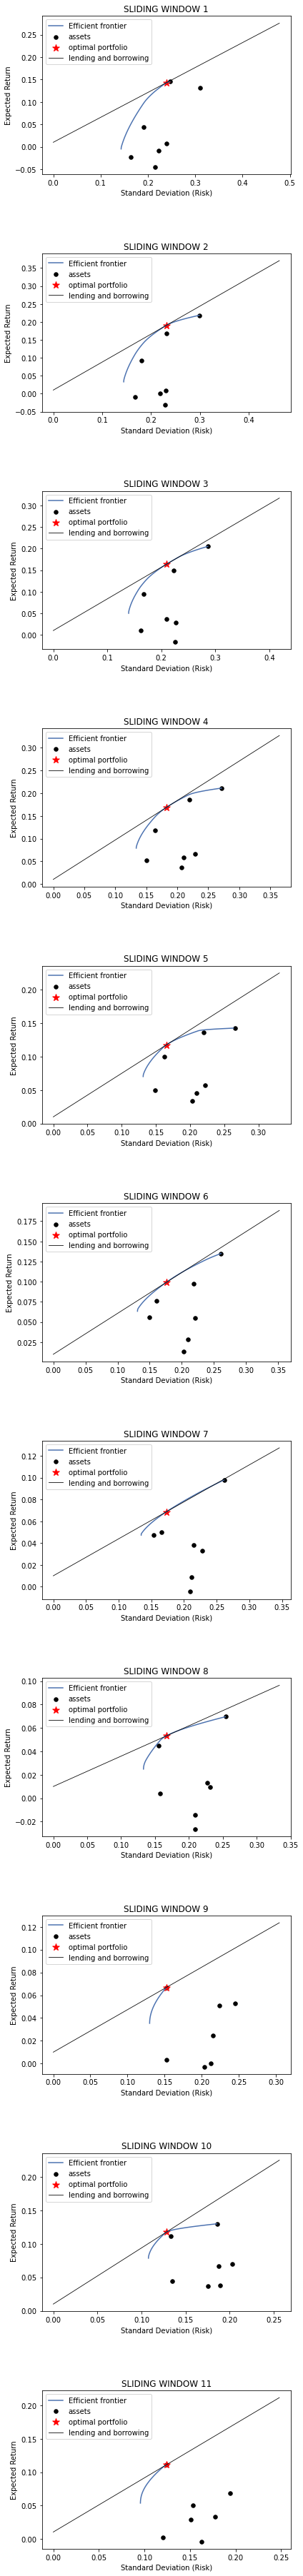

In [21]:
Rf = 0.01


fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    #need to create another instance
    ef2 = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    Best_portfolio = ef2.max_sharpe(risk_free_rate=0) #best portfolio weights
    stats = ef2.portfolio_performance(verbose=False, risk_free_rate=0)
    Rp = stats[0]
    sigma = stats[1]
    
    xs = np.linspace(0, 2)
    sigma_c = xs * sigma # slide 22 ch05
    Rc = Rf + (Rp - Rf)/sigma * sigma_c
    
    
    opt = axs[i].scatter(sigma, Rp, marker = '*', c = 'red', s=100, label = 'optimal portfolio')#best performance portfolio
    line1, = axs[i].plot(sigma_c, Rc, "-", color="k", linewidth=0.8, label = 'lending and borrowing')
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    axs[i].legend()
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()


### 5 real bonds data

In [8]:
#10Y coupon = 4.125, price at 14:42, 10/01/23: 104.3281 maturity = 15 NOV 2032
#30Y coupon = 4, 105.1406, 10/01/23 at 14:40 maturity = 15 NOV 2052
#5Y coupon = 3.875, price at 10/01/23, 100.6641, 14:40 maturity = 31 DEC 2027
#3Y coupon = 4, , price 99.9766 14:40 maturity = 15 DEC 2025
#2Y coupon = 4.25, price 99.9727 at 10/01/23, 14:39 maturity 31 DEC 2024
#data imported from investing.com from 01/01/2022 to 10/01/2023 (in order to get more data even if it's outside set date)

In [9]:
prices = [99.9727, 99.9766, 100.6641, 104.3281, 105.1406 ]
coupons = [4, 4.25, 3.875, 4.125, 4]
periods = [2,3,5,10,30] #years to maturity
YTM = []
face_value = 100

### for YTM we can compute the yield with the newton method specifying the correct formula for each bond as done below

##### This got kinda out of hand, maybe you should use your code again cause it's easier to understand

In [10]:
from scipy.optimize import newton
C_t = lambda coupon: (100 * coupon/100)/2
lambda_function = lambda y, p, coupon, price: sum([(C_t(coupon)/((1+y/2)**a)) for a in list(range(1,p))]) + (face_value + C_t(coupon))/((1+y/2)**p) - price

In [11]:
for period, coupon, price in zip(periods, coupons, prices):
    US_lambda = lambda y: lambda_function(y, period*2, coupon, price)
    r = round(newton(US_lambda, 0.01)*100,2)
    print(f"YTM US{period}Y: " + str(r))
    YTM.append(r)

YTM US2Y: 4.01
YTM US3Y: 4.26
YTM US5Y: 3.73
YTM US10Y: 3.61
YTM US30Y: 3.71


### We can automitize the previous procedure by using some approximation formula (in this way we can automize the yield to maturity based on period and so on ...) that return really similar values:

In [12]:
def YTM_func(price, face, coupon, periods):
    def bond_price_calc(YTM):
        return ((coupon*((1-(1+YTM)**-periods))/YTM)+((face)/(1+YTM)**periods))-price
    return bond_price_calc

In [13]:
for i in range(5):
    r = round(newton(YTM_func(price=prices[i],face=100,coupon=coupons[i],periods=periods[i]), 0.01)*100, 2)
    print("YTM (APPROXIMATION) BOND " +str(i) + ": " + str(r))

YTM (APPROXIMATION) BOND 0: 4.01
YTM (APPROXIMATION) BOND 1: 4.26
YTM (APPROXIMATION) BOND 2: 3.73
YTM (APPROXIMATION) BOND 3: 3.6
YTM (APPROXIMATION) BOND 4: 3.71


In [14]:
### tutorial youtube
###https://www.investopedia.com/terms/d/duration.asp

import numpy as np
import pandas as pd
import bond_pricing

def Duration(rate, coupon_rate, frequency, face_value, settlement_date, maturity_date, change_in_yield):
    
    try:
        settlement_date = pd.to_datetime(settlement_date, format="%d/%m/%Y")
    except:
        settlement_date = pd.to_datetime(settlement_date, format="%d-%m-%Y")
        
    try:
        maturity_date = pd.to_datetime(maturity_date, format="%d/%m/%Y")
    except:
        maturity_date = pd.to_datetime(maturity_date, format="%d-%m-%Y")
    
    data = pd.DataFrame()
    rate = rate/100
    coupon_rate = coupon_rate/100
    
    #duration
    n = pd.to_numeric(((pd.to_datetime(maturity_date) - pd.to_datetime(settlement_date))/365).days)
    total_payment = n*frequency #(years times payment freq)
    coupon_payment = coupon_rate/frequency * face_value
    payment = [coupon_payment] *(total_payment-1) + [coupon_payment + face_value] ## all payments [coup, coup, ... coup+par]
    data['period'] = pd.DataFrame(np.arange(1,total_payment + 1)) # number of payments (arange skip last value)
    data['payment'] = pd.DataFrame(payment)
    data['dcoupon'] = data['payment'] / ((1 + rate/frequency)**data['period'])
    data['pv'] = data['dcoupon'] / frequency * data['period'] / data['dcoupon'].sum()#duration formula per period
    duration = data['pv'].sum() #sum to obtain duration
    m_duration = duration / (1+ (rate/frequency))
    
    
    #convexity
    #factor = 1/(data['dcoupon'].sum() * (1+rate/frequency)**2)
    
    #as in the book:
    data['cf'] = (data['payment']*(data['period']**2 + data['period'])) / (1+rate/frequency)**data['period']
    convexity = 0.5* data['cf'].sum() / data['dcoupon'].sum()
    
    #price change = duration + conv  effcts
    price_change = (-duration * change_in_yield ) + ( convexity * (change_in_yield)**2 )
    
    bond_price = data['dcoupon'].sum()#bond_pricing.simple_bonds.bond_price(settle=settlement_date, cpn=coupon_rate, mat=maturity_date, yld=rate, freq=frequency, face=face_value)
    
    corrected_price = (bond_price* price_change) + bond_price  
    
    return duration, m_duration, convexity, price_change, bond_price, corrected_price, data
    
    
    
    
    
       

C:\Users\fiori\AppData\Roaming\Python\Python310\site-packages\bond_pricing\simple_bonds.py:528: UserWarning: Module isda_daycounters is not installed.
Only 'simple' daycount (basically ACT/365) is available.
To use other daycounts, install isda_daycounters from
https://github.com/miradulo/isda_daycounters
  warn("Module isda_daycounters is not installed.\n"


# Book example

In [15]:
Duration(10, 0, 1,1000, "01/01/2022", "01/01/2027", 0.02)
#bond_pricing.simple_bonds.bond_duration(settle="01/01/2022", mat="01/01/2032", cpn=5/100, yld=5/100, freq=1)

(5.0,
 4.545454545454545,
 15.000000000000002,
 -0.094,
 620.9213230591549,
 562.5547186915944,
    period  payment     dcoupon   pv            cf
 0       1      0.0    0.000000  0.0      0.000000
 1       2      0.0    0.000000  0.0      0.000000
 2       3      0.0    0.000000  0.0      0.000000
 3       4      0.0    0.000000  0.0      0.000000
 4       5   1000.0  620.921323  5.0  18627.639692)

In [16]:
#US2Y

BOND (US2Y) DURATION = 1.9419352947537565
BOND (US2Y) CONVEXITY = 9.613539354385738


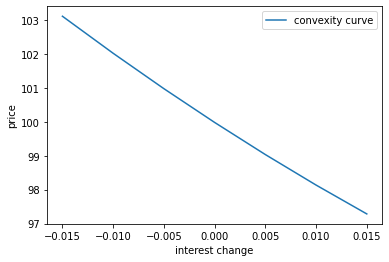

In [17]:
import matplotlib.pyplot as plt
face_value = 100

results = Duration(YTM[0], coupons[0],2, face_value, "31-12-2022", "31-12-2024", 0)
duration = results[0]
convexity = results[2]
print("BOND (US2Y) DURATION = " + str(duration))
print("BOND (US2Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[0],2, face_value, "31-12-2022", "31-12-2024", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US3Y) DURATION = 2.8488086394505134
BOND (US3Y) CONVEXITY = 19.59351515165304


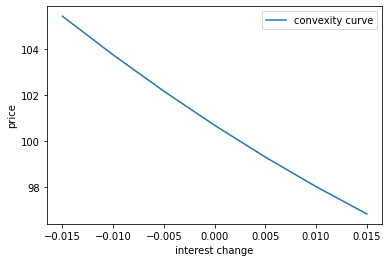

In [18]:
#US3Y
face_value = 100

results = Duration(YTM[0], coupons[1], 2, face_value, "15-12-2022", "15-12-2025", 0)
duration = results[0]
convexity = results[2]
print("BOND (US3Y) DURATION = " + str(duration))
print("BOND (US3Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US5Y) DURATION = 4.591805091170343
BOND (US5Y) CONVEXITY = 49.0522517857535


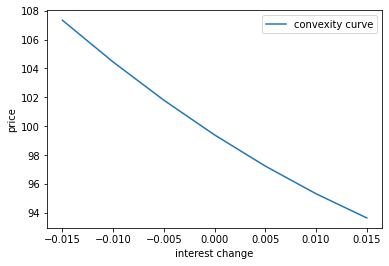

In [19]:
#US5Y
face_value = 100

results = Duration(YTM[0], coupons[2], 2, face_value, "31-12-2022", "31-12-2027", 0)
duration = results[0]
convexity = results[2]
print("BOND (US5Y) DURATION = " + str(duration))
print("BOND (US5Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US10Y) DURATION = 8.3038253906861
BOND (US10Y) CONVEXITY = 163.19543111717024


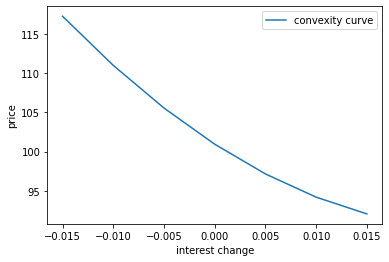

In [20]:
#US10Y
face_value = 100

results = Duration(YTM[0], coupons[3], 2, face_value, "15-11-2022", "15-11-2032", 0)
duration = results[0]
convexity = results[2]
print("BOND (US10Y) DURATION = " + str(duration))
print("BOND (US10Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

BOND (US30Y) DURATION = 17.716809939673254
BOND (US30Y) CONVEXITY = 874.8512662891465


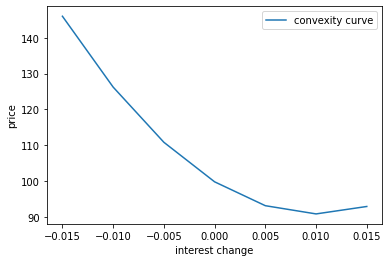

In [21]:
#US30Y
face_value = 100

results = Duration(YTM[0], coupons[4], 2, face_value, "15-11-2022", "15-11-2052", 0)
duration = results[0]
convexity = results[2]
print("BOND (US30Y) DURATION = " + str(duration))
print("BOND (US30Y) CONVEXITY = " + str(convexity))

#print how price will change with some intresets rates changes

interest_rate_shift = [-0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015]
l= []
for i in interest_rate_shift:
    l.append(Duration(YTM[0], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", i)[5])
plt.plot(interest_rate_shift, l, label="convexity curve")

plt.xlabel("interest change")
plt.ylabel('price')
plt.legend()

## Bonds portfolio

In [22]:
#conversion
from forex_python.converter import CurrencyRates

c = CurrencyRates()

USD = 100000 * c.get_rate('EUR', 'USD')

In [23]:
USD

107470.0

In [24]:
prices     #market prices

[99.9727, 99.9766, 100.6641, 104.3281, 105.1406]

In [25]:
bonds_portfolio = []
for p in prices:
    num_bonds = int(USD/ p)
    bonds_portfolio.append(num_bonds)
bonds_portfolio

[1074, 1074, 1067, 1030, 1022]

In [26]:
spent = np.array(bonds_portfolio) * np.array(prices)# how much was spent for each bond
#compute weights:
weights = spent/ spent.sum()
weights

array([0.19992091, 0.19992871, 0.19999151, 0.20008339, 0.20007548])

In [27]:
#Duration of portfolio:

durations = []
durations.append(round(Duration(YTM[0], coupons[0], 2, face_value, "31-12-2022", "31-12-2024", 0)[0],2))
durations.append(round(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", 0)[0],2))
durations.append(round(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", 0)[0],2))
durations.append(round(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", 0)[0],2))
durations.append(round(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", 0)[0],2))
durations

[1.94, 2.85, 4.59, 8.34, 18.05]

In [28]:
#Convexity of portfolio:

convs = []
convs.append(round(Duration(YTM[0], coupons[0], 2, face_value, "31-12-2022", "31-12-2024", 0)[2],2))
convs.append(round(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", 0)[2],2))
convs.append(round(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", 0)[2],2))
convs.append(round(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", 0)[2],2))
convs.append(round(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", 0)[2],2))
convs

[9.61, 19.59, 49.1, 164.04, 898.15]

In [29]:
print("Duration of portfolio: "+ str((weights * durations).sum()))

Duration of portfolio: 7.155662304057235


In [30]:
print("Convexity of portfolio: "+ str((weights * convs).sum()))

Convexity of portfolio: 228.17689786018988


### compute market value loss as yield increases

In [31]:
#change in price with 150 basis increase in yield:
new_prices = []
new_prices.append(round(Duration(YTM[0], coupons[0], 2, face_value, "31-12-2022", "31-12-2024", 0.015)[5],2))
new_prices.append(round(Duration(YTM[1], coupons[1], 2, face_value,  "15-12-2022", "15-12-2025", 0.015)[5],2))
new_prices.append(round(Duration(YTM[2], coupons[2], 2, face_value,  "31-12-2022", "31-12-2027", 0.015)[5],2))
new_prices.append(round(Duration(YTM[3], coupons[3], 2, face_value,  "15-11-2022", "15-11-2032", 0.015)[5],2))
new_prices.append(round(Duration(YTM[4], coupons[4], 2, face_value,  "15-11-2022", "15-11-2052", 0.015)[5],2))
new_prices # new prices after change in yield

[97.28, 96.14, 94.83, 95.1, 97.99]

In [32]:
price_c = (np.array(bonds_portfolio) * np.array(new_prices)).sum()

In [33]:
ini_price = (np.array(bonds_portfolio) * np.array(prices)).sum()

In [34]:
loss = (price_c - ini_price) / ini_price

print("the portfolio market value had decreased by: "+ str(round(loss, 4 ) * 100) + "%") 

the portfolio market value had decreased by: -5.6000000000000005%


In [35]:
#control:
print(ini_price + (ini_price * loss))
price_c

507015.47


507015.47

In [36]:
(7.5/100 * (10 / 365)) * 20000

41.0958904109589

## Computing dirty prices

In [37]:
def dirty_price(PV, payments_per_period, t, coupon, face_value): #t=days since last payment day
    coupon = coupon/100
    interest =  coupon/payments_per_period * t/365 *face_value
    return PV + interest

In [38]:
#prices #market prices (present value)
#YTM #yields to maturity
def compute_dirty_prices(num_payments_period, init_date, end_date,current_date, PV, YTM, coupon, face_value):
    #num_payments_period = 2
    init_date = pd.to_datetime(init_date, format="%d/%m/%Y") #day after the market prices where taken
    end_date = pd.to_datetime(end_date, format="%d/%m/%Y")
    current_date = pd.to_datetime(current_date, format="%d/%m/%Y")
    
    days_to_m = pd.to_numeric(((pd.to_datetime(end_date) - pd.to_datetime(init_date))).days) #days until maturity
    time_passed = days_to_m - pd.to_numeric(((pd.to_datetime(end_date) - pd.to_datetime(current_date))).days)
    
    years = days_to_m/365
    days_per_period = days_to_m / (years*num_payments_period)

    periods = years*num_payments_period
    dirty_prices = []
    total_days = 0
    for period in range(int(periods)):
        loop = int(days_per_period)
        if period % num_payments_period == 1: #add 1 day in odd periods, IT'S ALWAYS 2 IN MY CASE
            loop += 1
        for days_passed in range(loop):#I need to start from the 10/01
            if total_days > time_passed:
                dirty_prices.append(dirty_price(PV, num_payments_period, days_passed, coupon, face_value))
            total_days+=1
    
    dirty_prices.append(dirty_price(PV, num_payments_period, 0, coupon, face_value))#last value to complete the plot    
    return dirty_prices, time_passed, total_days

Text(0, 0.5, 'Price')

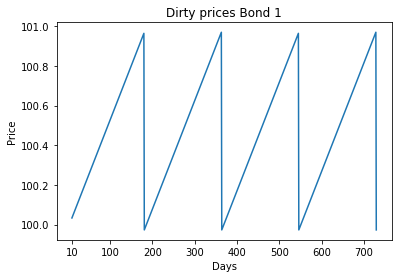

In [39]:
d_prices, time_passed, tot_days = compute_dirty_prices(2, "31/12/2022","31/12/2024","10/01/2023", prices[0], YTM[0], coupons[0], 100)
#plt.plot(np.array(range(len(d_prices)))+10, d_prices)
#plt.plot(np.array(range(10 , 730)), d_prices) #same

fig, ax = plt.subplots(1,1)
ticks =[x for x in range(len(d_prices)) if x%100 == 0]
ticks.append(time_passed)
ticks.remove(0)
p=ax.plot(np.array(range(len(d_prices)))+10, d_prices)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_title("Dirty prices Bond 1")
ax.set_xlabel('Days')
ax.set_ylabel('Price')
#ax.set_xlim([10, 730])

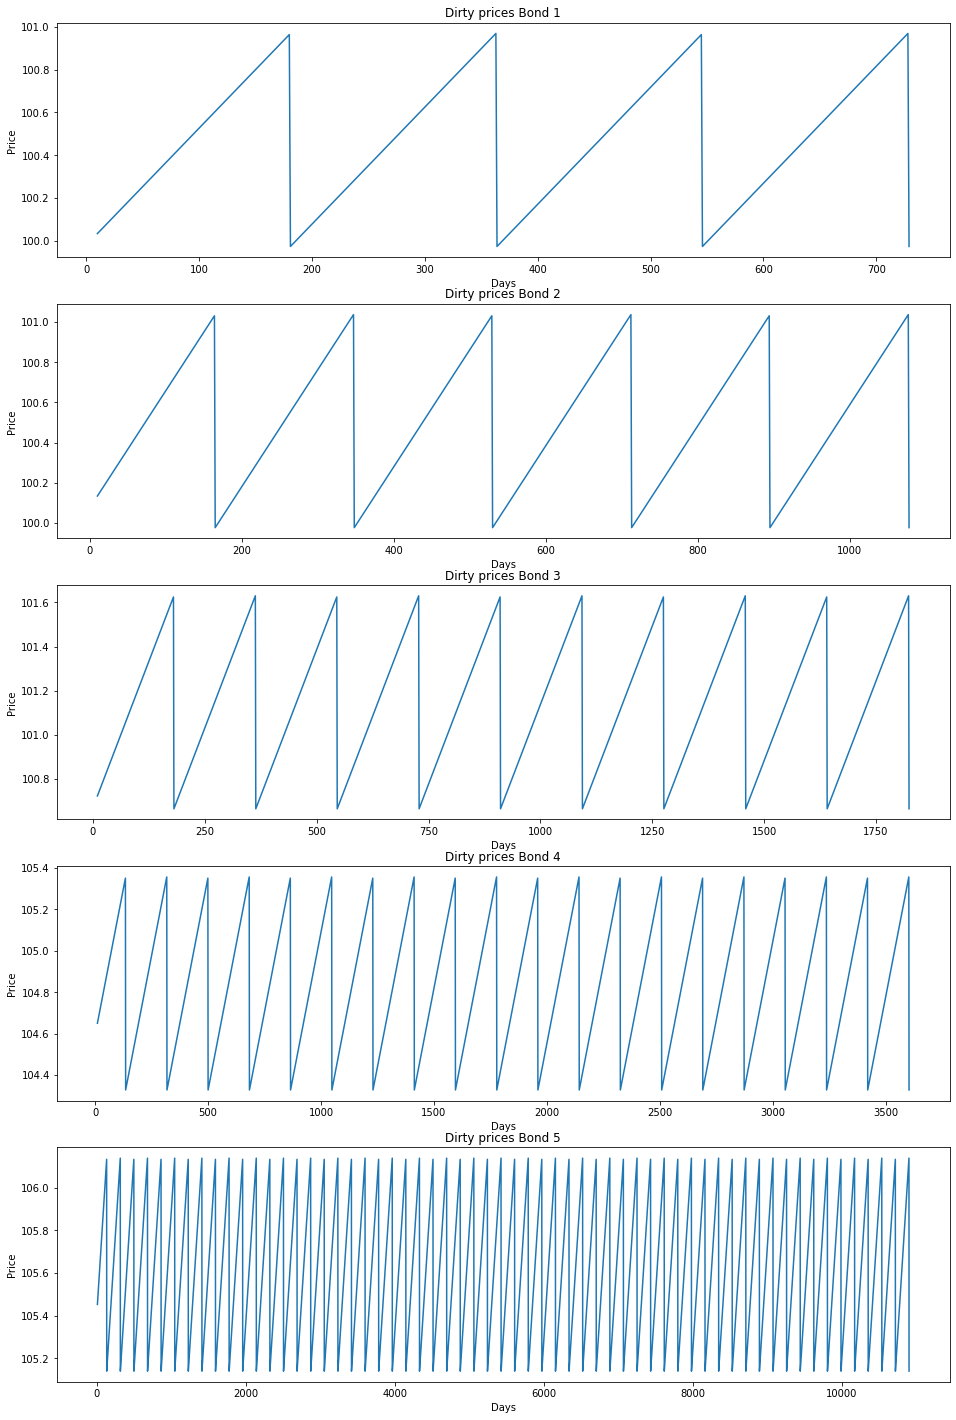

In [40]:
current_date = "10/01/2023"
start_dates = [ "31/12/2022","15/12/2022", "31/12/2022", "15/11/2022","15/11/2022" ]
end_dates = [ "31/12/2024","15/12/2025", "31/12/2027", "15/11/2032","15/11/2052" ]

bonds_d_p = []

fig, ax = plt.subplots(5, figsize=(16, 25))

for i in range(5):
    d_prices, time_passed, tot_days = compute_dirty_prices(2, start_dates[i],end_dates[i],current_date, prices[i], YTM[i], coupons[i], face_value)
    bonds_d_p.append(d_prices)
    
    ticks =[x for x in range(len(d_prices)) if x%100 == 0]
    ticks.append(time_passed)
    ticks.remove(0)
    p=ax[i].plot(np.array(range(len(d_prices)))+10, d_prices)
    #ax[i].set_xticks(ticks)
    #ax[i].set_xticklabels(ticks)
    ax[i].set_title("Dirty prices Bond " + str(i+1))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Price')
    #ax.set_xlim([10, 730])

# Apply dirty prices to portfolio

In [41]:
#plot the market value of the portfolio against days, every time a bond is matured remove it ofc.

In [42]:
#IF I BUY THE BONDS THE 10/01/2023 I WIL BUY THEM AT THE DIRTY PRICE
initial_prices = [bonds_d_p[0][0], bonds_d_p[1][0], bonds_d_p[2][0], bonds_d_p[3][0], bonds_d_p[4][0]]

In [43]:
bonds_portfolio = []
for p in initial_prices:
    num_bonds = int(USD/ p)
    bonds_portfolio.append(num_bonds)
bonds_portfolio #less than before, the market price didn't consider the dirty price bcs it's a treasury bond

[1074, 1073, 1066, 1026, 1019]

In [44]:
spent = np.array(bonds_portfolio) * np.array(initial_prices)# how much was spent for each bond
#compute weights:
weights = spent/ spent.sum()
weights

array([0.20003735, 0.20005251, 0.19991588, 0.19991759, 0.20007667])

In [45]:
#making all array of same length
for i in range(len(bonds_d_p)):
    N = len(bonds_d_p[4]) - len(bonds_d_p[i])
    bonds_d_p[i] = np.pad(bonds_d_p[i], (0, N), 'constant')

In [46]:
sums = np.zeros(len(bonds_d_p[4]))
for x in bonds_d_p:
    sums += x
    
sums*= 100000

Text(0, 0.5, 'value')

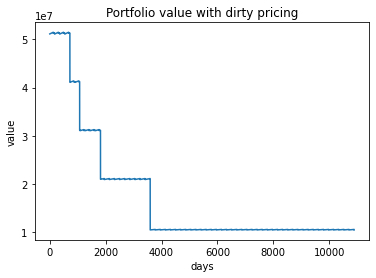

In [47]:
plt.plot(sums)
plt.title("Portfolio value with dirty pricing")
plt.xlabel("days")
plt.ylabel("value")
#note that the segmented lines are the dirty pricing effects and the shape similar to a step function it's because the 
#bonds will mature in that date and thus the portfolio will decrease in value since we will receive the money for that bond